In [21]:
import os
import gc
import sys
import numpy as np
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

import matplotlib.pyplot as plt
import IPython.display as ipd

In [22]:
if torch.cuda.is_available():
            print('CUDA available')
            print(torch.cuda.get_device_name(0))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
            
else:
    print('WARNING: CUDA is not available')

CUDA available
NVIDIA GeForce RTX 3060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [23]:
# Global Vars
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = "./Data/genres_original/"
csv_3 = "./Data/features_3_sec.csv"
csv_30 = "./Data/features_30_sec.csv"

audio_paths = [f for f in Path(path).glob('*\*.wav')]

batch_size = 32
num_workers = 0
epochs = 100

sample_rate = 44100
n_mels = 128
n_mfcc = 40

melkwargs = {
    'hop_length' : 300,
    'f_min' : 20,
    'f_max' : sample_rate // 2,
    'n_mels' : n_mels,
    'n_fft' : n_mels * 20}


validation_split = .2

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 1) # set default size of plots

print(audio_paths[:10])

[WindowsPath('Data/genres_original/blues/blues.00000.wav'), WindowsPath('Data/genres_original/blues/blues.00001.wav'), WindowsPath('Data/genres_original/blues/blues.00002.wav'), WindowsPath('Data/genres_original/blues/blues.00003.wav'), WindowsPath('Data/genres_original/blues/blues.00004.wav'), WindowsPath('Data/genres_original/blues/blues.00005.wav'), WindowsPath('Data/genres_original/blues/blues.00006.wav'), WindowsPath('Data/genres_original/blues/blues.00007.wav'), WindowsPath('Data/genres_original/blues/blues.00008.wav'), WindowsPath('Data/genres_original/blues/blues.00009.wav')]


In [24]:
# Local Dataset
# data = DataLoader(path, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

# get class mapping
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

classes, class_dict = find_classes(path)

print(classes, list(class_dict.items())[:10])

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'] [('blues', 0), ('classical', 1), ('country', 2), ('disco', 3), ('hiphop', 4), ('jazz', 5), ('metal', 6), ('pop', 7), ('reggae', 8), ('rock', 9)]


In [25]:
# Dataset
# Data in the Models folder containts 100 audio samples per class
# This function splits audio into 80/20 train and test splits
class GTZAN(Dataset):
        def __init__(self, paths: list, transform=None):
                self.paths = paths
                self.transform = transform
        
        def __len__(self):
                return len(self.paths)

        def __getitem__(self, index):              
                signal, sr = torchaudio.load(self.paths[index])
                if self.transform:
                        signal = self.transform(signal)
                        signal = torch.flatten(signal, start_dim=1, end_dim=-1)
                label = self.paths[index].__str__().split('\\')[2]
                return signal, label        

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        tensors += [waveform]
        targets += [torch.tensor(class_dict[label])]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets      


#############################################################################################################################         

test_paths = []
train_paths = []
for genre in classes:
        # get list of audio files in that genre
        samples = [f for f in Path(path).glob(f'*\{genre}.*.wav')]

        # Split list 80:20
        trainlist = samples[:80] # first 80
        testlist = samples[80:] 
        test_paths.extend(testlist)
        train_paths.extend(trainlist)

transform = nn.Sequential(
        torchaudio.transforms.Resample(sample_rate),
        torchaudio.transforms.MFCC(sample_rate, n_mfcc=n_mfcc, melkwargs=melkwargs)
)

train_set = GTZAN(train_paths, transform=transform)
test_set = GTZAN(test_paths, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers, collate_fn=collate_fn)


In [26]:
# visualise one audio sample
sample = train_set[0][0]
print("Shape of waveform: {}".format(train_set[0][0].shape))
# plt.plot(sample.t().numpy())

Shape of waveform: torch.Size([1, 32040])


In [27]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=10, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=40, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [28]:
input_size = train_set[0][0].shape[0]
model = M5(n_input=input_size, n_output=len(classes))
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after n epochs by a factor of gamma

n = count_parameters(model)
print("Number of parameters: %s" % n)


M5(
  (conv1): Conv1d(1, 32, kernel_size=(40,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=10, bias=True)
)
Numbe

In [29]:
def train(model, epoch, log_interval):
    model.train()
    best_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)
        if loss.item() > best_loss:
            best_loss = loss.item()
            torch.save({
                    'epoch': epoch + 1,
                    'arch': 'CNN',
                    'state_dict': model.state_dict(),
                    'optimizer' : optimizer.state_dict(),
                    'scheduler' : scheduler.state_dict()
                }, f'./cnn-mfcc.pth.tar')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch, best):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        # data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)
        acc = round(100. * correct / len(test_loader.dataset), 3)

        if acc > best[1]:
            best = (epoch, acc)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({acc}%)\n")

In [30]:
log_interval = 100
best = (0, 0)

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
with tqdm(total=epochs) as pbar:
    for epoch in range(1, epochs + 1):
        train(model, epoch, log_interval)
        test(model, epoch, best)
        scheduler.step()

  0%|          | 0.03125/100 [00:05<5:08:46, 185.32s/it]

Train Epoch: 1 [0/800 (0%)]	Loss: 2.384167


  1%|          | 0.96875/100 [00:17<19:07, 11.59s/it]   


Test Epoch: 1	Accuracy: 64/200 (32.0%)



  1%|          | 1.03125/100 [00:17<15:59,  9.70s/it]

Train Epoch: 2 [0/800 (0%)]	Loss: 1.641678


  2%|▏         | 1.96875/100 [00:28<18:39, 11.42s/it]


Test Epoch: 2	Accuracy: 30/200 (15.0%)



  2%|▏         | 2.03125/100 [00:29<16:29, 10.10s/it]

Train Epoch: 3 [0/800 (0%)]	Loss: 1.312754


  3%|▎         | 2.96875/100 [00:40<18:02, 11.16s/it]


Test Epoch: 3	Accuracy: 84/200 (42.0%)



  3%|▎         | 3.03125/100 [00:40<17:12, 10.65s/it]

Train Epoch: 4 [0/800 (0%)]	Loss: 1.812145


  4%|▍         | 3.96875/100 [00:51<18:17, 11.43s/it]


Test Epoch: 4	Accuracy: 63/200 (31.5%)



  4%|▍         | 4.03125/100 [00:52<15:28,  9.67s/it]

Train Epoch: 5 [0/800 (0%)]	Loss: 1.138376


  5%|▍         | 4.96875/100 [01:02<18:13, 11.50s/it]


Test Epoch: 5	Accuracy: 57/200 (28.5%)



  5%|▌         | 5.03125/100 [01:03<16:57, 10.72s/it]

Train Epoch: 6 [0/800 (0%)]	Loss: 1.668757


  6%|▌         | 5.96875/100 [01:14<17:36, 11.24s/it]


Test Epoch: 6	Accuracy: 79/200 (39.5%)



  6%|▌         | 6.03125/100 [01:14<15:25,  9.85s/it]

Train Epoch: 7 [0/800 (0%)]	Loss: 0.855153


  7%|▋         | 6.96875/100 [01:25<17:47, 11.48s/it]


Test Epoch: 7	Accuracy: 64/200 (32.0%)



  7%|▋         | 7.03125/100 [01:26<14:59,  9.68s/it]

Train Epoch: 8 [0/800 (0%)]	Loss: 0.904911


  8%|▊         | 8.0/100 [01:37<13:40,  8.92s/it]    


Test Epoch: 8	Accuracy: 62/200 (31.0%)



  8%|▊         | 8.03125/100 [01:37<14:48,  9.66s/it]

Train Epoch: 9 [0/800 (0%)]	Loss: 0.851807


  9%|▉         | 8.96875/100 [01:48<17:04, 11.26s/it]


Test Epoch: 9	Accuracy: 97/200 (48.5%)



  9%|▉         | 9.03125/100 [01:49<14:16,  9.42s/it]

Train Epoch: 10 [0/800 (0%)]	Loss: 0.551367


 10%|▉         | 9.96875/100 [02:00<17:35, 11.72s/it]


Test Epoch: 10	Accuracy: 74/200 (37.0%)



 10%|█         | 10.03125/100 [02:00<14:22,  9.59s/it]

Train Epoch: 11 [0/800 (0%)]	Loss: 0.717659


 11%|█         | 10.96875/100 [02:11<16:37, 11.20s/it]


Test Epoch: 11	Accuracy: 74/200 (37.0%)



 11%|█         | 11.03125/100 [02:12<14:19,  9.67s/it]

Train Epoch: 12 [0/800 (0%)]	Loss: 0.593685


 12%|█▏        | 11.96875/100 [02:23<16:24, 11.18s/it]


Test Epoch: 12	Accuracy: 76/200 (38.0%)



 12%|█▏        | 12.03125/100 [02:23<13:51,  9.45s/it]

Train Epoch: 13 [0/800 (0%)]	Loss: 0.423101


 13%|█▎        | 12.96875/100 [02:34<15:44, 10.85s/it]


Test Epoch: 13	Accuracy: 68/200 (34.0%)



 13%|█▎        | 13.03125/100 [02:34<13:56,  9.62s/it]

Train Epoch: 14 [0/800 (0%)]	Loss: 0.420172


 14%|█▍        | 13.96875/100 [02:45<15:59, 11.15s/it]


Test Epoch: 14	Accuracy: 88/200 (44.0%)



 14%|█▍        | 14.03125/100 [02:45<13:46,  9.61s/it]

Train Epoch: 15 [0/800 (0%)]	Loss: 0.448699


 15%|█▍        | 14.96875/100 [02:56<15:43, 11.10s/it]


Test Epoch: 15	Accuracy: 71/200 (35.5%)



 15%|█▌        | 15.03125/100 [02:57<13:10,  9.30s/it]

Train Epoch: 16 [0/800 (0%)]	Loss: 0.507443


 16%|█▌        | 15.96875/100 [03:08<15:54, 11.36s/it]


Test Epoch: 16	Accuracy: 90/200 (45.0%)



 16%|█▌        | 16.03125/100 [03:08<13:15,  9.47s/it]

Train Epoch: 17 [0/800 (0%)]	Loss: 0.336210


 17%|█▋        | 16.96875/100 [03:19<16:09, 11.67s/it]


Test Epoch: 17	Accuracy: 80/200 (40.0%)



 17%|█▋        | 17.03125/100 [03:20<13:19,  9.64s/it]

Train Epoch: 18 [0/800 (0%)]	Loss: 0.230148


 18%|█▊        | 17.96875/100 [03:30<14:45, 10.79s/it]


Test Epoch: 18	Accuracy: 56/200 (28.0%)



 18%|█▊        | 18.03125/100 [03:31<12:08,  8.89s/it]

Train Epoch: 19 [0/800 (0%)]	Loss: 0.210321


 19%|█▉        | 18.96875/100 [03:41<15:11, 11.25s/it]


Test Epoch: 19	Accuracy: 53/200 (26.5%)



 19%|█▉        | 19.03125/100 [03:42<12:52,  9.54s/it]

Train Epoch: 20 [0/800 (0%)]	Loss: 0.283507


 20%|█▉        | 19.96875/100 [03:53<15:05, 11.31s/it]


Test Epoch: 20	Accuracy: 79/200 (39.5%)



 20%|██        | 20.03125/100 [03:53<12:30,  9.38s/it]

Train Epoch: 21 [0/800 (0%)]	Loss: 0.090280


 21%|██        | 20.96875/100 [04:04<14:41, 11.16s/it]


Test Epoch: 21	Accuracy: 101/200 (50.5%)



 21%|██        | 21.03125/100 [04:05<13:23, 10.18s/it]

Train Epoch: 22 [0/800 (0%)]	Loss: 0.079761


 22%|██▏       | 21.96875/100 [04:15<14:26, 11.10s/it]


Test Epoch: 22	Accuracy: 106/200 (53.0%)



 22%|██▏       | 22.03125/100 [04:15<12:22,  9.53s/it]

Train Epoch: 23 [0/800 (0%)]	Loss: 0.118348


 23%|██▎       | 22.96875/100 [04:26<15:13, 11.87s/it]


Test Epoch: 23	Accuracy: 103/200 (51.5%)



 23%|██▎       | 23.03125/100 [04:27<12:12,  9.51s/it]

Train Epoch: 24 [0/800 (0%)]	Loss: 0.043238


 24%|██▍       | 23.96875/100 [04:37<14:13, 11.23s/it]


Test Epoch: 24	Accuracy: 104/200 (52.0%)



 24%|██▍       | 24.03125/100 [04:38<12:02,  9.51s/it]

Train Epoch: 25 [0/800 (0%)]	Loss: 0.074128


 25%|██▌       | 25.0/100 [04:49<10:48,  8.65s/it]    


Test Epoch: 25	Accuracy: 105/200 (52.5%)



 25%|██▌       | 25.03125/100 [04:49<12:10,  9.74s/it]

Train Epoch: 26 [0/800 (0%)]	Loss: 0.078277


 26%|██▌       | 25.96875/100 [05:00<13:34, 11.01s/it]


Test Epoch: 26	Accuracy: 104/200 (52.0%)



 26%|██▌       | 26.03125/100 [05:00<11:43,  9.51s/it]

Train Epoch: 27 [0/800 (0%)]	Loss: 0.105388


 27%|██▋       | 26.96875/100 [05:11<14:00, 11.51s/it]


Test Epoch: 27	Accuracy: 102/200 (51.0%)



 27%|██▋       | 27.03125/100 [05:12<11:49,  9.73s/it]

Train Epoch: 28 [0/800 (0%)]	Loss: 0.051352


 28%|██▊       | 27.96875/100 [05:23<14:34, 12.15s/it]


Test Epoch: 28	Accuracy: 102/200 (51.0%)



 28%|██▊       | 28.03125/100 [05:23<11:56,  9.96s/it]

Train Epoch: 29 [0/800 (0%)]	Loss: 0.034814


 29%|██▉       | 28.96875/100 [05:34<13:11, 11.15s/it]


Test Epoch: 29	Accuracy: 104/200 (52.0%)



 29%|██▉       | 29.03125/100 [05:34<11:10,  9.44s/it]

Train Epoch: 30 [0/800 (0%)]	Loss: 0.051314


 30%|███       | 30.0/100 [05:45<10:31,  9.02s/it]    


Test Epoch: 30	Accuracy: 99/200 (49.5%)



 30%|███       | 30.03125/100 [05:46<11:24,  9.78s/it]

Train Epoch: 31 [0/800 (0%)]	Loss: 0.050022


 31%|███       | 30.96875/100 [05:57<12:45, 11.08s/it]


Test Epoch: 31	Accuracy: 104/200 (52.0%)



 31%|███       | 31.03125/100 [05:57<10:47,  9.39s/it]

Train Epoch: 32 [0/800 (0%)]	Loss: 0.048905


 32%|███▏      | 31.96875/100 [06:08<12:44, 11.23s/it]


Test Epoch: 32	Accuracy: 102/200 (51.0%)



 32%|███▏      | 32.03125/100 [06:08<10:58,  9.69s/it]

Train Epoch: 33 [0/800 (0%)]	Loss: 0.031727


 33%|███▎      | 32.96875/100 [06:19<12:44, 11.40s/it]


Test Epoch: 33	Accuracy: 102/200 (51.0%)



 33%|███▎      | 33.03125/100 [06:20<11:22, 10.19s/it]

Train Epoch: 34 [0/800 (0%)]	Loss: 0.056776


 34%|███▍      | 33.96875/100 [06:31<12:35, 11.43s/it]


Test Epoch: 34	Accuracy: 105/200 (52.5%)



 34%|███▍      | 34.03125/100 [06:31<10:39,  9.69s/it]

Train Epoch: 35 [0/800 (0%)]	Loss: 0.035246


 35%|███▍      | 34.96875/100 [06:42<11:44, 10.83s/it]


Test Epoch: 35	Accuracy: 101/200 (50.5%)



 35%|███▌      | 35.03125/100 [06:42<09:51,  9.11s/it]

Train Epoch: 36 [0/800 (0%)]	Loss: 0.031083


 36%|███▌      | 35.96875/100 [06:53<12:17, 11.52s/it]


Test Epoch: 36	Accuracy: 102/200 (51.0%)



 36%|███▌      | 36.03125/100 [06:54<10:10,  9.54s/it]

Train Epoch: 37 [0/800 (0%)]	Loss: 0.022649


 37%|███▋      | 36.96875/100 [07:04<11:53, 11.32s/it]


Test Epoch: 37	Accuracy: 107/200 (53.5%)



 37%|███▋      | 37.03125/100 [07:05<09:57,  9.50s/it]

Train Epoch: 38 [0/800 (0%)]	Loss: 0.015227


 38%|███▊      | 37.96875/100 [07:16<11:06, 10.74s/it]


Test Epoch: 38	Accuracy: 98/200 (49.0%)



 38%|███▊      | 38.03125/100 [07:16<09:21,  9.06s/it]

Train Epoch: 39 [0/800 (0%)]	Loss: 0.025286


 39%|███▉      | 38.96875/100 [07:27<11:25, 11.23s/it]


Test Epoch: 39	Accuracy: 97/200 (48.5%)



 39%|███▉      | 39.03125/100 [07:27<09:41,  9.53s/it]

Train Epoch: 40 [0/800 (0%)]	Loss: 0.025516


 40%|███▉      | 39.96875/100 [07:38<11:24, 11.41s/it]


Test Epoch: 40	Accuracy: 99/200 (49.5%)



 40%|████      | 40.03125/100 [07:39<09:37,  9.64s/it]

Train Epoch: 41 [0/800 (0%)]	Loss: 0.072086


 41%|████      | 40.96875/100 [07:49<11:10, 11.36s/it]


Test Epoch: 41	Accuracy: 101/200 (50.5%)



 41%|████      | 41.03125/100 [07:50<09:22,  9.54s/it]

Train Epoch: 42 [0/800 (0%)]	Loss: 0.028813


 42%|████▏     | 41.96875/100 [08:01<10:38, 11.01s/it]


Test Epoch: 42	Accuracy: 101/200 (50.5%)



 42%|████▏     | 42.03125/100 [08:01<09:09,  9.48s/it]

Train Epoch: 43 [0/800 (0%)]	Loss: 0.021908


 43%|████▎     | 42.96875/100 [08:12<10:51, 11.43s/it]


Test Epoch: 43	Accuracy: 104/200 (52.0%)



 43%|████▎     | 43.03125/100 [08:13<09:09,  9.65s/it]

Train Epoch: 44 [0/800 (0%)]	Loss: 0.105243


 44%|████▍     | 43.96875/100 [08:23<10:28, 11.23s/it]


Test Epoch: 44	Accuracy: 101/200 (50.5%)



 44%|████▍     | 44.03125/100 [08:24<08:44,  9.38s/it]

Train Epoch: 45 [0/800 (0%)]	Loss: 0.060652


 45%|████▍     | 44.96875/100 [08:34<10:06, 11.03s/it]


Test Epoch: 45	Accuracy: 102/200 (51.0%)



 45%|████▌     | 45.03125/100 [08:35<08:38,  9.43s/it]

Train Epoch: 46 [0/800 (0%)]	Loss: 0.016223


 46%|████▌     | 45.96875/100 [08:46<09:43, 10.81s/it]


Test Epoch: 46	Accuracy: 99/200 (49.5%)



 46%|████▌     | 46.03125/100 [08:46<08:12,  9.13s/it]

Train Epoch: 47 [0/800 (0%)]	Loss: 0.025803


 47%|████▋     | 46.96875/100 [08:57<09:56, 11.25s/it]


Test Epoch: 47	Accuracy: 100/200 (50.0%)



 47%|████▋     | 47.03125/100 [08:57<08:25,  9.54s/it]

Train Epoch: 48 [0/800 (0%)]	Loss: 0.044064


 48%|████▊     | 47.96875/100 [09:08<09:31, 10.99s/it]


Test Epoch: 48	Accuracy: 103/200 (51.5%)



 48%|████▊     | 48.03125/100 [09:09<08:03,  9.31s/it]

Train Epoch: 49 [0/800 (0%)]	Loss: 0.022412


 49%|████▉     | 48.96875/100 [09:20<09:40, 11.37s/it]


Test Epoch: 49	Accuracy: 100/200 (50.0%)



 49%|████▉     | 49.03125/100 [09:20<08:17,  9.75s/it]

Train Epoch: 50 [0/800 (0%)]	Loss: 0.014482


 50%|█████     | 50.0/100 [09:31<07:22,  8.84s/it]    


Test Epoch: 50	Accuracy: 101/200 (50.5%)



 50%|█████     | 50.03125/100 [09:31<08:21, 10.04s/it]

Train Epoch: 51 [0/800 (0%)]	Loss: 0.022212


 51%|█████     | 50.96875/100 [09:42<09:10, 11.22s/it]


Test Epoch: 51	Accuracy: 105/200 (52.5%)



 51%|█████     | 51.03125/100 [09:43<07:36,  9.32s/it]

Train Epoch: 52 [0/800 (0%)]	Loss: 0.029091


 52%|█████▏    | 51.96875/100 [09:53<09:00, 11.25s/it]


Test Epoch: 52	Accuracy: 100/200 (50.0%)



 52%|█████▏    | 52.03125/100 [09:54<07:34,  9.47s/it]

Train Epoch: 53 [0/800 (0%)]	Loss: 0.020577


 53%|█████▎    | 52.96875/100 [10:04<08:50, 11.29s/it]


Test Epoch: 53	Accuracy: 104/200 (52.0%)



 53%|█████▎    | 53.03125/100 [10:05<07:34,  9.68s/it]

Train Epoch: 54 [0/800 (0%)]	Loss: 0.048043


 54%|█████▍    | 53.96875/100 [10:16<08:38, 11.27s/it]


Test Epoch: 54	Accuracy: 100/200 (50.0%)



 54%|█████▍    | 54.03125/100 [10:16<07:21,  9.60s/it]

Train Epoch: 55 [0/800 (0%)]	Loss: 0.020920


 55%|█████▍    | 54.96875/100 [10:27<08:19, 11.10s/it]


Test Epoch: 55	Accuracy: 104/200 (52.0%)



 55%|█████▌    | 55.03125/100 [10:27<07:06,  9.48s/it]

Train Epoch: 56 [0/800 (0%)]	Loss: 0.015301


 56%|█████▌    | 55.96875/100 [10:38<08:13, 11.21s/it]


Test Epoch: 56	Accuracy: 100/200 (50.0%)



 56%|█████▌    | 56.03125/100 [10:39<06:42,  9.16s/it]

Train Epoch: 57 [0/800 (0%)]	Loss: 0.034316


 57%|█████▋    | 56.96875/100 [10:49<08:03, 11.24s/it]


Test Epoch: 57	Accuracy: 104/200 (52.0%)



 57%|█████▋    | 57.03125/100 [10:50<06:53,  9.61s/it]

Train Epoch: 58 [0/800 (0%)]	Loss: 0.030346


 58%|█████▊    | 57.96875/100 [11:01<07:43, 11.03s/it]


Test Epoch: 58	Accuracy: 102/200 (51.0%)



 58%|█████▊    | 58.03125/100 [11:01<06:32,  9.36s/it]

Train Epoch: 59 [0/800 (0%)]	Loss: 0.012497


 59%|█████▉    | 58.96875/100 [11:12<07:33, 11.05s/it]


Test Epoch: 59	Accuracy: 105/200 (52.5%)



 59%|█████▉    | 59.03125/100 [11:12<06:30,  9.53s/it]

Train Epoch: 60 [0/800 (0%)]	Loss: 0.020321


 60%|█████▉    | 59.96875/100 [11:23<07:33, 11.33s/it]


Test Epoch: 60	Accuracy: 103/200 (51.5%)



 60%|██████    | 60.03125/100 [11:24<06:20,  9.53s/it]

Train Epoch: 61 [0/800 (0%)]	Loss: 0.037955


 61%|██████    | 60.96875/100 [11:35<07:16, 11.18s/it]


Test Epoch: 61	Accuracy: 98/200 (49.0%)



 61%|██████    | 61.03125/100 [11:35<06:00,  9.25s/it]

Train Epoch: 62 [0/800 (0%)]	Loss: 0.076190


 62%|██████▏   | 61.96875/100 [11:46<07:07, 11.23s/it]


Test Epoch: 62	Accuracy: 102/200 (51.0%)



 62%|██████▏   | 62.03125/100 [11:47<05:51,  9.26s/it]

Train Epoch: 63 [0/800 (0%)]	Loss: 0.076253


 63%|██████▎   | 62.96875/100 [11:57<06:57, 11.28s/it]


Test Epoch: 63	Accuracy: 101/200 (50.5%)



 63%|██████▎   | 63.03125/100 [11:58<06:08,  9.96s/it]

Train Epoch: 64 [0/800 (0%)]	Loss: 0.038382


 64%|██████▍   | 63.96875/100 [12:09<06:38, 11.05s/it]


Test Epoch: 64	Accuracy: 102/200 (51.0%)



 64%|██████▍   | 64.03125/100 [12:09<05:34,  9.29s/it]

Train Epoch: 65 [0/800 (0%)]	Loss: 0.020128


 65%|██████▍   | 64.96875/100 [12:20<06:20, 10.87s/it]


Test Epoch: 65	Accuracy: 101/200 (50.5%)



 65%|██████▌   | 65.03125/100 [12:21<05:19,  9.13s/it]

Train Epoch: 66 [0/800 (0%)]	Loss: 0.022491


 66%|██████▌   | 65.96875/100 [12:32<06:17, 11.08s/it]


Test Epoch: 66	Accuracy: 102/200 (51.0%)



 66%|██████▌   | 66.03125/100 [12:32<05:13,  9.24s/it]

Train Epoch: 67 [0/800 (0%)]	Loss: 0.023371


 67%|██████▋   | 66.96875/100 [12:43<06:12, 11.27s/it]


Test Epoch: 67	Accuracy: 102/200 (51.0%)



 67%|██████▋   | 67.03125/100 [12:43<05:20,  9.72s/it]

Train Epoch: 68 [0/800 (0%)]	Loss: 0.021996


 68%|██████▊   | 67.96875/100 [12:54<06:01, 11.29s/it]


Test Epoch: 68	Accuracy: 102/200 (51.0%)



 68%|██████▊   | 68.03125/100 [12:55<05:04,  9.53s/it]

Train Epoch: 69 [0/800 (0%)]	Loss: 0.051109


 69%|██████▉   | 68.96875/100 [13:05<05:46, 11.18s/it]


Test Epoch: 69	Accuracy: 102/200 (51.0%)



 69%|██████▉   | 69.03125/100 [13:06<04:58,  9.63s/it]

Train Epoch: 70 [0/800 (0%)]	Loss: 0.066235


 70%|██████▉   | 69.96875/100 [13:17<05:29, 10.98s/it]


Test Epoch: 70	Accuracy: 99/200 (49.5%)



 70%|███████   | 70.03125/100 [13:17<04:43,  9.45s/it]

Train Epoch: 71 [0/800 (0%)]	Loss: 0.022196


 71%|███████   | 70.96875/100 [13:28<05:43, 11.82s/it]


Test Epoch: 71	Accuracy: 102/200 (51.0%)



 71%|███████   | 71.03125/100 [13:29<04:41,  9.72s/it]

Train Epoch: 72 [0/800 (0%)]	Loss: 0.036456


 72%|███████▏  | 71.96875/100 [13:39<05:10, 11.08s/it]


Test Epoch: 72	Accuracy: 102/200 (51.0%)



 72%|███████▏  | 72.03125/100 [13:40<04:18,  9.24s/it]

Train Epoch: 73 [0/800 (0%)]	Loss: 0.017557


 73%|███████▎  | 72.96875/100 [13:51<04:53, 10.87s/it]


Test Epoch: 73	Accuracy: 101/200 (50.5%)



 73%|███████▎  | 73.03125/100 [13:51<04:02,  9.01s/it]

Train Epoch: 74 [0/800 (0%)]	Loss: 0.025345


 74%|███████▍  | 73.96875/100 [14:02<05:10, 11.93s/it]


Test Epoch: 74	Accuracy: 102/200 (51.0%)



 74%|███████▍  | 74.03125/100 [14:03<04:14,  9.81s/it]

Train Epoch: 75 [0/800 (0%)]	Loss: 0.017376


 75%|███████▍  | 74.96875/100 [14:13<04:39, 11.15s/it]


Test Epoch: 75	Accuracy: 100/200 (50.0%)



 75%|███████▌  | 75.03125/100 [14:14<03:49,  9.17s/it]

Train Epoch: 76 [0/800 (0%)]	Loss: 0.056114


 76%|███████▌  | 75.96875/100 [14:25<04:28, 11.17s/it]


Test Epoch: 76	Accuracy: 103/200 (51.5%)



 76%|███████▌  | 76.03125/100 [14:25<03:45,  9.39s/it]

Train Epoch: 77 [0/800 (0%)]	Loss: 0.017967


 77%|███████▋  | 76.96875/100 [14:36<04:13, 11.03s/it]


Test Epoch: 77	Accuracy: 103/200 (51.5%)



 77%|███████▋  | 77.03125/100 [14:36<03:27,  9.05s/it]

Train Epoch: 78 [0/800 (0%)]	Loss: 0.025960


 78%|███████▊  | 77.96875/100 [14:47<04:09, 11.33s/it]


Test Epoch: 78	Accuracy: 105/200 (52.5%)



 78%|███████▊  | 78.03125/100 [14:48<03:29,  9.55s/it]

Train Epoch: 79 [0/800 (0%)]	Loss: 0.026079


 79%|███████▉  | 78.96875/100 [14:58<03:51, 11.00s/it]


Test Epoch: 79	Accuracy: 102/200 (51.0%)



 79%|███████▉  | 79.03125/100 [14:59<03:20,  9.56s/it]

Train Epoch: 80 [0/800 (0%)]	Loss: 0.018225


 80%|███████▉  | 79.96875/100 [15:10<03:43, 11.15s/it]


Test Epoch: 80	Accuracy: 100/200 (50.0%)



 80%|████████  | 80.03125/100 [15:10<03:16,  9.82s/it]

Train Epoch: 81 [0/800 (0%)]	Loss: 0.033982


 81%|████████  | 80.96875/100 [15:21<03:40, 11.57s/it]


Test Epoch: 81	Accuracy: 102/200 (51.0%)



 81%|████████  | 81.03125/100 [15:22<03:01,  9.56s/it]

Train Epoch: 82 [0/800 (0%)]	Loss: 0.029734


 82%|████████▏ | 81.96875/100 [15:33<03:22, 11.26s/it]


Test Epoch: 82	Accuracy: 102/200 (51.0%)



 82%|████████▏ | 82.03125/100 [15:33<02:49,  9.42s/it]

Train Epoch: 83 [0/800 (0%)]	Loss: 0.028260


 83%|████████▎ | 83.0/100 [15:44<02:33,  9.05s/it]    


Test Epoch: 83	Accuracy: 103/200 (51.5%)



 83%|████████▎ | 83.03125/100 [15:44<02:45,  9.73s/it]

Train Epoch: 84 [0/800 (0%)]	Loss: 0.016538


 84%|████████▍ | 83.96875/100 [15:55<03:03, 11.45s/it]


Test Epoch: 84	Accuracy: 98/200 (49.0%)



 84%|████████▍ | 84.03125/100 [15:56<02:30,  9.44s/it]

Train Epoch: 85 [0/800 (0%)]	Loss: 0.015831


 85%|████████▍ | 84.96875/100 [16:07<02:48, 11.22s/it]


Test Epoch: 85	Accuracy: 100/200 (50.0%)



 85%|████████▌ | 85.03125/100 [16:07<02:19,  9.32s/it]

Train Epoch: 86 [0/800 (0%)]	Loss: 0.024062


 86%|████████▌ | 85.96875/100 [16:19<02:47, 11.94s/it]


Test Epoch: 86	Accuracy: 103/200 (51.5%)



 86%|████████▌ | 86.03125/100 [16:19<02:20, 10.09s/it]

Train Epoch: 87 [0/800 (0%)]	Loss: 0.043338


 87%|████████▋ | 86.96875/100 [16:30<02:28, 11.38s/it]


Test Epoch: 87	Accuracy: 104/200 (52.0%)



 87%|████████▋ | 87.03125/100 [16:30<02:04,  9.61s/it]

Train Epoch: 88 [0/800 (0%)]	Loss: 0.016636


 88%|████████▊ | 87.96875/100 [16:41<02:12, 11.00s/it]


Test Epoch: 88	Accuracy: 102/200 (51.0%)



 88%|████████▊ | 88.03125/100 [16:42<01:52,  9.40s/it]

Train Epoch: 89 [0/800 (0%)]	Loss: 0.018066


 89%|████████▉ | 88.96875/100 [16:52<02:02, 11.13s/it]


Test Epoch: 89	Accuracy: 103/200 (51.5%)



 89%|████████▉ | 89.03125/100 [16:53<01:44,  9.52s/it]

Train Epoch: 90 [0/800 (0%)]	Loss: 0.019470


 90%|████████▉ | 89.96875/100 [17:03<01:51, 11.14s/it]


Test Epoch: 90	Accuracy: 102/200 (51.0%)



 90%|█████████ | 90.03125/100 [17:04<01:34,  9.47s/it]

Train Epoch: 91 [0/800 (0%)]	Loss: 0.017891


 91%|█████████ | 91.0/100 [17:15<01:21,  9.01s/it]    


Test Epoch: 91	Accuracy: 102/200 (51.0%)



 91%|█████████ | 91.03125/100 [17:15<01:27,  9.81s/it]

Train Epoch: 92 [0/800 (0%)]	Loss: 0.019148


 92%|█████████▏| 91.96875/100 [17:26<01:31, 11.41s/it]


Test Epoch: 92	Accuracy: 102/200 (51.0%)



 92%|█████████▏| 92.03125/100 [17:27<01:16,  9.63s/it]

Train Epoch: 93 [0/800 (0%)]	Loss: 0.017245


 93%|█████████▎| 92.96875/100 [17:37<01:18, 11.15s/it]


Test Epoch: 93	Accuracy: 105/200 (52.5%)



 93%|█████████▎| 93.03125/100 [17:38<01:05,  9.47s/it]

Train Epoch: 94 [0/800 (0%)]	Loss: 0.020824


 94%|█████████▍| 93.96875/100 [17:48<01:07, 11.14s/it]


Test Epoch: 94	Accuracy: 102/200 (51.0%)



 94%|█████████▍| 94.03125/100 [17:49<00:57,  9.55s/it]

Train Epoch: 95 [0/800 (0%)]	Loss: 0.019286


 95%|█████████▍| 94.96875/100 [18:00<00:55, 11.08s/it]


Test Epoch: 95	Accuracy: 100/200 (50.0%)



 95%|█████████▌| 95.03125/100 [18:00<00:47,  9.56s/it]

Train Epoch: 96 [0/800 (0%)]	Loss: 0.014736


 96%|█████████▌| 95.96875/100 [18:11<00:44, 11.15s/it]


Test Epoch: 96	Accuracy: 105/200 (52.5%)



 96%|█████████▌| 96.03125/100 [18:11<00:38,  9.64s/it]

Train Epoch: 97 [0/800 (0%)]	Loss: 0.015647


 97%|█████████▋| 96.96875/100 [18:22<00:33, 11.20s/it]


Test Epoch: 97	Accuracy: 100/200 (50.0%)



 97%|█████████▋| 97.03125/100 [18:22<00:28,  9.47s/it]

Train Epoch: 98 [0/800 (0%)]	Loss: 0.080222


 98%|█████████▊| 98.0/100 [18:33<00:17,  8.84s/it]    


Test Epoch: 98	Accuracy: 101/200 (50.5%)



 98%|█████████▊| 98.03125/100 [18:34<00:19,  9.81s/it]

Train Epoch: 99 [0/800 (0%)]	Loss: 0.022165


 99%|█████████▉| 98.96875/100 [18:44<00:11, 11.31s/it]


Test Epoch: 99	Accuracy: 102/200 (51.0%)



 99%|█████████▉| 99.03125/100 [18:45<00:09,  9.48s/it]

Train Epoch: 100 [0/800 (0%)]	Loss: 0.015799


100%|██████████| 100.0/100 [18:56<00:00, 11.36s/it]   


Test Epoch: 100	Accuracy: 102/200 (51.0%)



Text(0.5, 1.0, 'training loss')

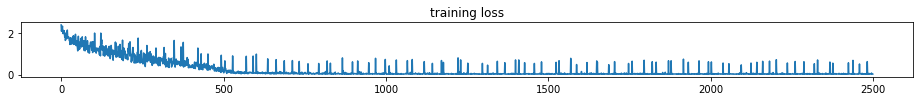

In [31]:

plt.plot(losses)
plt.title("training loss")